<h1><center>Sartorius: Cell Instance Segmentation</center></h1>
                                                      
<center><img src = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS75MhDku1itW_qJxDfBwBywPP2ROhw0Vh9Dah3QllbkQW1h9gvBsQnWkScUikzJ7mvPJM&usqp=CAU" width = "750" height = "500"/></center>       

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Load Modules</center></h2>

In [1]:
import os
import copy

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torchvision

from torchvision.transforms import functional as F
#import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import cv2

import albumentations as A
import albumentations.pytorch
from albumentations import (HorizontalFlip, VerticalFlip, 
                            ShiftScaleRotate, Normalize, Resize, 
                            Compose, GaussNoise)
from albumentations.pytorch import ToTensorV2



import random
import numpy as np
import pandas as pd
import scipy.ndimage as ndi
from tqdm import tqdm, tqdm_notebook

import pickle
from pathlib import Path
import PIL

import GPUtil
from GPUtil import showUtilization as gpu_usage

import matplotlib.pyplot as plt
import seaborn as sns
from skimage.filters import threshold_otsu
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from jupyterthemes import jtplot
import warnings

import time
from functools import wraps
import functools
import collections

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

%matplotlib inline

#torch.backends.cudnn.benchmark = True
#torch.backends.cudnn.enabled = True

In [3]:
def set_random(n):
    random.seed(n)
    np.random.seed(n)
    torch.manual_seed(n)
    torch.cuda.manual_seed(n)
    torch.cuda.manual_seed_all(n)
    torch.backends.cudnn.deterministic = True
    os.environ['PYTHONHASHSEED'] = str(n)
    
set_random(42)

# Configuration

In [47]:
data_dir = './sartorius-cell-instance-segmentation'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 2
NUM_EPOCHS = 5
TRAIN_CSV = f"{data_dir}/train.csv"
TRAIN_PATH = f"{data_dir}/train"
TEST_PATH = f"{data_dir}/test"
WIDTH = 704
HEIGHT = 520
# Threshold for mask length
TH = 40
BATCH_SIZE = 2
WEIGHT_DECAY = 0.0005


# Normalize to resnet mean and std if True.
RESNET_MEAN = (0.485, 0.456, 0.406)
RESNET_STD = (0.229, 0.224, 0.225)
IMAGE_RESIZE = (224, 224)


cell_type_dict = {"astro": 1, "cort": 2, "shsy5y": 3}

# Load data

In [5]:
train_files = sorted(list(Path(TRAIN_PATH).rglob('*png')))
test_files = sorted(list(Path(TEST_PATH).rglob('*.png')))
print(f'Number of pictures in train dir: {len(train_files)} pcs')
print()
print(f'Number of pictures in test dir: {len(test_files)} pcs')

Number of pictures in train dir: 606 pcs

Number of pictures in test dir: 3 pcs


In [6]:
cell_df = pd.read_csv(TRAIN_CSV)
cell_df.info()
cell_df.sample(4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73585 entries, 0 to 73584
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 73585 non-null  object
 1   annotation         73585 non-null  object
 2   width              73585 non-null  int64 
 3   height             73585 non-null  int64 
 4   cell_type          73585 non-null  object
 5   plate_time         73585 non-null  object
 6   sample_date        73585 non-null  object
 7   sample_id          73585 non-null  object
 8   elapsed_timedelta  73585 non-null  object
dtypes: int64(2), object(7)
memory usage: 5.1+ MB


,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
65518,de504eaa5349,252178 6 252881 8 253585 9 254288 10 254992 11...,704,520,shsy5y,11h30m00s,2019-06-15,shsy5y[diff]_D12-1_Vessel-714_Ph_2,0 days 11:30:00
48139,a76fe4d00355,112202 6 112905 10 113608 11 114314 9 115018 9...,704,520,shsy5y,11h30m00s,2019-06-14,shsy5y[diff]_E10-2_Vessel-714_Ph_3,0 days 11:30:00
37042,836e5872684a,268741 3 269440 10 270138 18 270839 23 271544 ...,704,520,shsy5y,11h30m00s,2019-06-14,shsy5y[diff]_D12-4_Vessel-714_Ph_4,0 days 11:30:00
60537,d09291445961,125348 8 126050 11 126753 13 127457 15 128162 ...,704,520,astro,09h00m00s,2020-09-14,astros[cereb]_F8-2_Vessel-361_Ph_4,0 days 09:00:00


# Utils

In [7]:
def rle_decode(mask_rle,shape,color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    if colors = 1, then:
    Returns numpy array, 1 - mask, 0 - background
    '''
    
    s = mask_rle.split()
    # get starting pixel and cells's length
    start, length = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    start -=1
    # Ending pixels
    ends = start + length
    img = np.zeros((shape[0] * shape[1], shape [2]), dtype=np.float32)
    for lo, hi in zip (start, ends):
        img[lo : hi] = color
    return img.reshape(shape)

In [8]:
# def rle_decode(mask_rle,shape,color=1):
#     '''
#     mask_rle: run-length as string formated (start length)
#     shape: (height, width, channels) of array to return 
#     color: color for the mask
#     Returns numpy array (mask)

#     '''
    
#     s=mask_rle.split()
    
#     starts=list(map(lambda x: int(x) -1, s[0::2])) # start array which contain list of start indices
#     lengths=list(map(int, s[1::2]))
#     ends=[x+y for x,y in zip(starts,lengths)]
    
#     img=np.zeros((shape[0]*shape[1],shape[2]),dtype=np.float32)
    
#     for start,end in zip(starts,ends):
#         img[start:end]=color
        
#     return img.reshape(shape)

In [9]:
def clean_mask(mask):
    '''
    Function is called to identify whether the mask is broken
    returns True or False state and also returns a mask
    '''
    mask = mask > threshold_otsu(np.array(mask).astype(np.uint8))
    mask = ndi.binary_fill_holes(mask).astype(np.uint8)
    
    # New code for mask acceptance
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    c = contours[0][:, 0]
    diff = c - np.roll(c, 1, 0)
    # find horizontal lines longer than threshold
    targets = (diff[:, 1] == 0) & (np.abs(diff[:, 0]) >= TH)  
    
    return mask, (True in targets)

In [10]:
def build_mask(labels, input_shape, colors=True):
    height, width = input_shape
    masks = np.zeros((height, width, 1))
    #masks = np.zeros((height,width), dtype=np.uint8)
    for i, label in enumerate(labels):
        a_mask = rle_decode(label, shape=(height,width, 1))
        a_mask = np.array(a_mask) > 0 #0 !!!!!!!!!!!!!!!!!!
        a_mask, broken_mask = clean_mask(a_mask)
        if broken_mask:
            continue
        masks += a_mask
    masks = masks.clip(0,1)
    return masks

In [11]:
# def build_mask(labels, input_shape, colors=True):
#     height, width = input_shape
#     if colors:
#         mask = np.zeros((height, width, 3))
#         for label in labels:
#             mask += rle_decode(label, shape=(height,width,3), color=np.random.rand(3))
#     else:
#         mask = np.zeros((height, width, 1))
#         for label in labels:
#             mask += rle_decode(label, shape=(height,width, 1))
#     mask = mask.clip(0,1)
#     return mask

# Visualize the Data

--- 3.814697265625e-06 seconds in label ---
--- 0.003368377685546875 seconds in sorting df ---
--- 5.249633073806763 seconds in mask1 ---
--- 5.186467885971069 seconds in mask2 ---


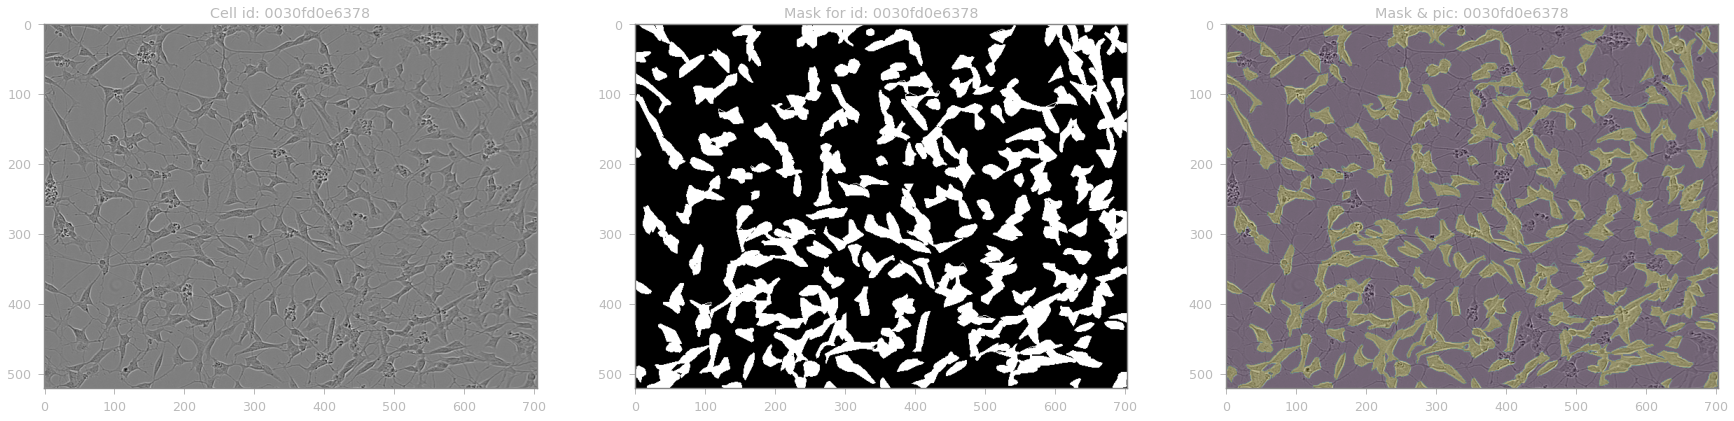

--- 4.0531158447265625e-06 seconds in label ---
--- 0.003087282180786133 seconds in sorting df ---
--- 1.2194185256958008 seconds in mask1 ---
--- 1.2508666515350342 seconds in mask2 ---


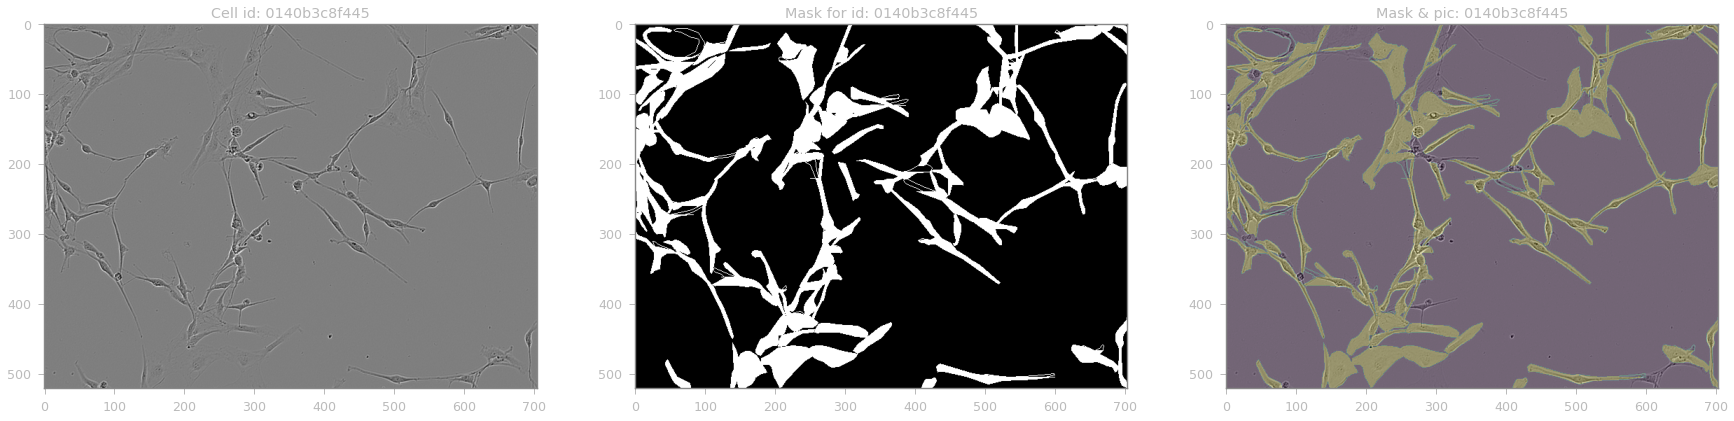

--- 3.814697265625e-06 seconds in label ---
--- 0.0034165382385253906 seconds in sorting df ---
--- 0.41443705558776855 seconds in mask1 ---
--- 0.40998029708862305 seconds in mask2 ---


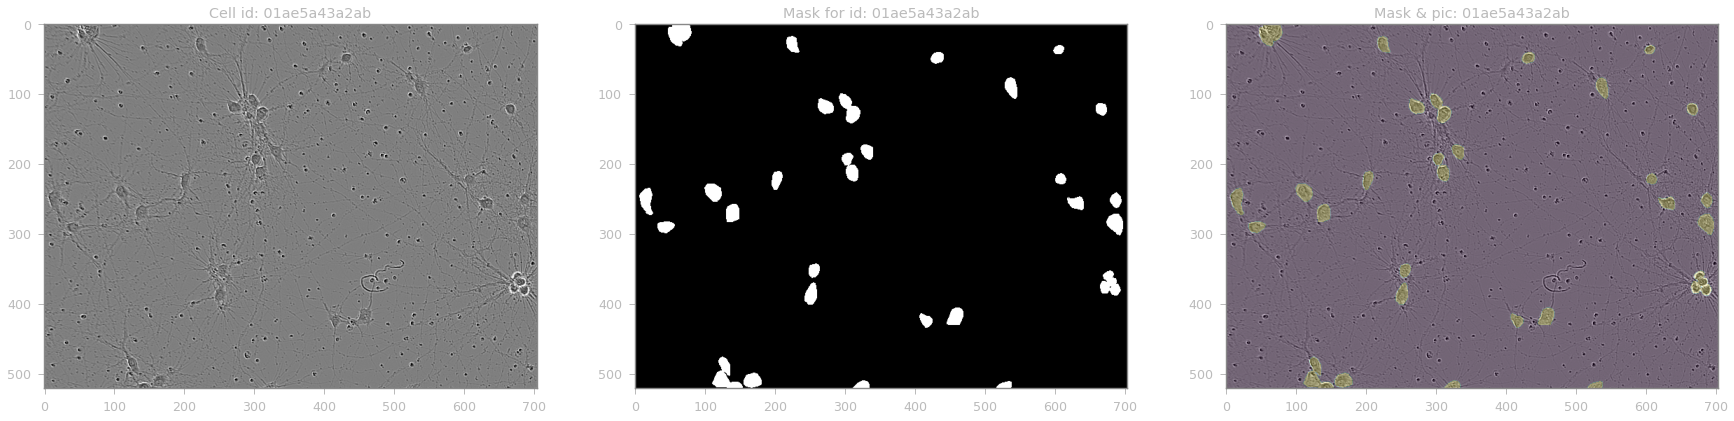

--- 4.5299530029296875e-06 seconds in label ---
--- 0.0032927989959716797 seconds in sorting df ---
--- 0.48879146575927734 seconds in mask1 ---
--- 0.47113513946533203 seconds in mask2 ---


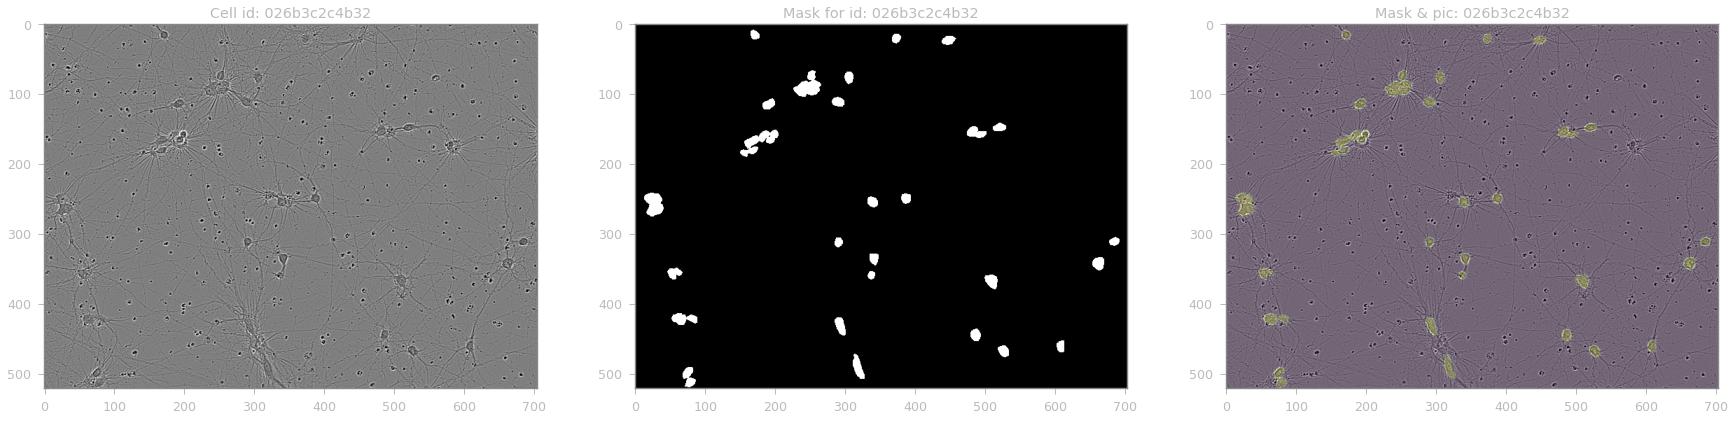

In [12]:
for i in range(4):
    #rand_idx = int(np.random.uniform(0, 607))
    #im = PIL.Image.open(train_files[rand_idx])
    im = PIL.Image.open(train_files[i])
    #label = (train_files[rand_idx]).name[:-4]
    
    start = time.time()
    label = (train_files[i]).stem#name[:-4]
    print("--- %s seconds in label ---" % (time.time() - start))
    
    start = time.time()
    sample_im_df = cell_df[cell_df['id'] == label]
    print("--- %s seconds in sorting df ---" % (time.time() - start))
    
    sample_rles = sample_im_df['annotation'].values
    start = time.time()
    sample_masks1 = build_mask(sample_rles,input_shape=(HEIGHT,WIDTH), colors=False)
    print("--- %s seconds in mask1 ---" % (time.time() - start))
    
    start = time.time()
    sample_masks2 = build_mask(sample_rles,input_shape=(HEIGHT,WIDTH), colors=True)
    print("--- %s seconds in mask2 ---" % (time.time() - start))

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 20),)
    ax1.imshow(im,cmap='gray')
    ax2.imshow(sample_masks1, cmap='gray')
    ax3.imshow(im,cmap='gray')
    ax3.imshow(sample_masks2,alpha = .2)
    
    ax1.set_title('Cell id: ' + str(label))
    ax2.set_title('Mask for id: ' + str(label))
    ax3.set_title('Mask & pic: ' + str(label))
    plt.show();

# DataSets

## Define Dataset class

In [13]:
# def get_augmentation(pic_size,train:bool):
#     if train == False:
#         augmentation_test = albumentations.Compose([A.Resize(pic_size,pic_size),
#                                                     A.Normalize(
#                                                         mean=[0.485, 0.456, 0.406],
#                                                         std=[0.229, 0.224, 0.225]),
#                                                     A.pytorch.transforms.ToTensorV2()])
#         return augmentation_test
#     else:
#         augmentation_train = A.Compose([
#             A.Resize(pic_size,pic_size),
#             A.RandomCrop(pic_size, pic_size),
#             A.OneOf([
#                 A.HorizontalFlip(p=0.5),
#                 A.RandomRotate90(p=0.5),
#                 A.VerticalFlip(p=0.5)], p=0.5),
#             A.OneOf([
#                 A.GaussNoise(),], p=1),
# #             A.OneOf([
# #                 A.MotionBlur(p=0.2),
# #                 A.MedianBlur(blur_limit=3, p=0.1),
# #                 A.Blur(blur_limit=3, p=0.1),], p=0.8),
# #             A.ShiftScaleRotate(
# #                 shift_limit=0.0625, 
# #                 scale_limit=0.2, 
# #                 rotate_limit=15, p=1),
# #             A.OneOf([
# #                 A.OpticalDistortion(p=0.5),
# #                 A.GridDistortion(p=0.1),], p=0.5),
# #             A.OneOf([
# #                 A.CLAHE(clip_limit=2),
# #                 A.RandomBrightnessContrast(),], p=0.5),
# #             A.HueSaturationValue(p=0.3),
#             A.Normalize(
#                 mean=[0.485, 0.456, 0.406],
#                 std=[0.229, 0.224, 0.225]),
#             A.pytorch.transforms.ToTensorV2()], p=1)
#         return augmentation_train


In [14]:
class NeuroDataSet(Dataset):
    def __init__(self, files, df: pd.core.frame.DataFrame,train:bool): #transform=None):   
        self.files = files
        self.df = df
        #self.transform = transform
        self.height = HEIGHT
        self.width = WIDTH
        self.gb = self.df.groupby('id')#['annotation'].agg(lambda x: list(x)).reset_index()
        self.transforms_tr = Compose([Resize(IMAGE_RESIZE[0], IMAGE_RESIZE[1]), 
                                   Normalize(mean=RESNET_MEAN, std=RESNET_STD, p=1), 
                                   HorizontalFlip(p=0.5),
                                   VerticalFlip(p=0.5),
                                   ToTensorV2()])
        self.transforms_tst = Compose([Resize(IMAGE_RESIZE[0], IMAGE_RESIZE[1]), 
                                   Normalize(mean=RESNET_MEAN, std=RESNET_STD, p=1),
                                   ToTensorV2()])
        
        self.image_ids = df.id.unique().tolist()
        self.len_ = len(self.files)
        self.train = train
        
    
    def load_sample(self, file):
        img = cv2.imread(str(file), cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_id = file.stem
        return img, img_id
    
    def __getitem__(self,index):
        # load image
        img, img_id = self.load_sample(self.files[index])
        df_temp = self.gb.get_group(img_id)
        
        annotations = df_temp['annotation'].values
        mask = build_mask(annotations, (self.height,self.width), colors=False)
        mask = mask.astype('float32')
        if self.train:
            augmented = self.transforms_tr(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
            return img, mask.reshape((1, IMAGE_RESIZE[0], IMAGE_RESIZE[1]))
        else:
            augmented = self.transforms_tst(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
            return img, mask.reshape((1, IMAGE_RESIZE[0], IMAGE_RESIZE[1]))
        
    def __len__(self):
        return self.len_

In [15]:
# Split dataset to train and val sets
train_pics, val_pics = train_test_split(train_files, test_size=0.1)

In [16]:
# Extract pic Id from Path
train_pic_id = [path.stem for path in train_pics]
val_pic_id = [path.stem for path in val_pics]
# Print number of files in tran and val sets
print(f'Number of pictures in train set: {len(train_pics)}')
print()
print(f'Number of pictures in val set: {len(val_pics)}')

Number of pictures in train set: 545

Number of pictures in val set: 61


In [17]:
# split pandas dataframe with annotations for train df and val df
df_train = cell_df[(cell_df['id'].isin(train_pic_id))]
df_val = cell_df[(cell_df['id'].isin(val_pic_id))]

print(f"Number of picture's id in train set {df_train.id.nunique()}")
print()
print(f"Number of picture's id in val set {df_val.id.nunique()}")

Number of picture's id in train set 545

Number of picture's id in val set 61


In [18]:
train_dataset = NeuroDataSet(train_pics,
                             df_train,train=True
                             )

In [19]:
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          pin_memory=True,
                          num_workers=12,)

In [20]:
val_dataset = NeuroDataSet(val_pics,
                             df_val,train=False
                             )

In [21]:
val_loader = DataLoader(val_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          pin_memory=True,
                          num_workers=12,)

In [22]:
batch = next(iter(train_loader)) 

In [23]:
images, masks = batch
print(f"image shape: {images.shape},\nmask shape:{masks.shape},\nbatch len: {len(batch)}")

image shape: torch.Size([4, 3, 224, 224]),
mask shape:torch.Size([4, 1, 224, 224]),
batch len: 2


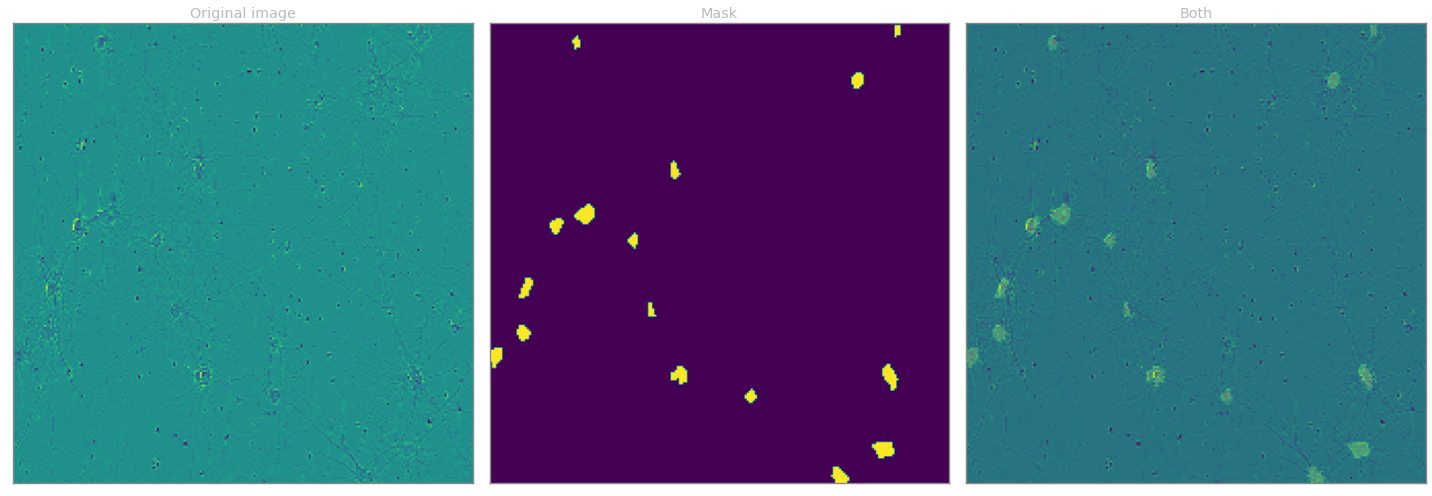

In [24]:
plt.figure(figsize=(20, 20))
        
plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(images[1][1])
plt.title('Original image')

plt.subplot( 1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(masks[1][0])
plt.title('Mask')

plt.subplot( 1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(images[1][1])
plt.imshow(masks[1][0],alpha=0.2)
plt.title('Both')
plt.tight_layout()
plt.show()

In [25]:
# cell_type_dict = {"astro": 1, "cort": 2, "shsy5y": 3}
# class NeuroDataSet(Dataset):
#     def __init__(self, files, df: pd.core.frame.DataFrame, transform=None, resize=False):
        
#         self.files = files
#         self.df = df
#         self.transform = transform
#         # resize height and width of image
#         self.should_resize = resize is not False
        
#         if self.should_resize:
#             self.height = int(HEIGHT*resize)
#             self.width = int(WIDTH*resize)
#             print("image size used:", self.height, self.width)
#         else:
#             self.height = HEIGHT
#             self.width = WIDTH
        
#         # Creating a default dict - image_info
#         # It provides a default value for the key that does not exists.
#         self.image_info = collections.defaultdict(dict)
#         # temp_df contain all annotations of particular image_id
#         temp_df = self.df.groupby(['id','cell_type'])['annotation'].agg(lambda x: list(x)).reset_index()
#         # image_info dict will contatin all info about particular image and its all annotations
#         for index, row in temp_df.iterrows():
#             self.image_info[index] = {
#                 'image_id': row['id'],
#                 #'image_path': os.path.join(self.files,row['id']+ '.png'),
#                 'annotation': row['annotation'],
#                 'cell_type': cell_type_dict[row["cell_type"]]
#             }
#     def get_box(self, a_mask):
#         ''' Get the bounding box of a given mask '''
#         # find out the position where a_mask=1
#         pos = np.where(a_mask)
#         # min pos will give min co-ordinate
#         xmin = np.min(pos[1])
#         # max-position give max co-ordinate
#         xmax = np.max(pos[1])
#         ymin = np.min(pos[0])
#         ymax = np.max(pos[0])
#         return [xmin, ymin, xmax, ymax]
    
#     def load_sample(self, file):
#         img = cv2.imread(str(file), cv2.IMREAD_COLOR)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         img_id = file.stem
#         return img, img_id
    
#     def __getitem__(self,index):
#         # load image
#         img, img_id = self.load_sample(self.files[index])
#         if self.should_resize:
#             #img = img.resize((self.width,self.height),resample=Image.BILINEAR)
#             img = cv2.resize(img, (self.width,self.height))
        
#         info = self.image_info[index]
#         #no. of objects present in an image
#         n_objects = len(info['annotation'])
#         # creating a masks of Zeros of shape(n_onjects,height,width)
#         masks = np.zeros((n_objects,self.height,self.width,1),dtype=np.uint8)
#         boxes = []
#         labels = []
#         for i, annotation in enumerate(info['annotation']):
#             a_mask = rle_decode(annotation, shape=(HEIGHT, WIDTH,1))
#             if self.should_resize:
#                 a_mask = cv2.resize(a_mask, (self.width, self.height))
            
#             a_mask = np.array(a_mask) > 0
#             a_mask, broken_mask = clean_mask(a_mask)
#             if broken_mask:
#                 continue
#             masks[i,:,:] = a_mask # store the ith mask
            
#             # finding the bounding box of respective mask for each annotation
#             boxes.append(self.get_box(a_mask))
        
#         # labels
#         labels = [int(info["cell_type"]) for _ in range(n_objects)]
#         # convert all into tensors
#         boxes=torch.as_tensor(boxes,dtype=torch.float32)
#         labels = torch.as_tensor(labels, dtype=torch.int64)
#         masks = torch.as_tensor(masks, dtype=torch.uint8)
        
#         area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
#         iscrowd = torch.zeros((n_objects,), dtype=torch.int64)
        
#         # This is the required target for the Mask R-CNN
#         target = {
#             'boxes': boxes,
#             'labels': labels,
#             'masks': masks,
#             'image_id': img_id,
#             'area': area,
#             'iscrowd': iscrowd
#         }
#         if self.transform is not None:
#             img, target = self.transform(img, target)
            
#         return img, target
    
#     def __len__(self):
#         return len(self.image_info)

In [26]:
# train_dataset = NeuroDataSet(train_pics,
#                              df_train,
#                              transform=get_transform(train=True))

In [27]:
# train_loader = DataLoader(train_dataset,
#                           batch_size=BATCH_SIZE,
#                           shuffle=True,
#                           pin_memory=True,
#                           num_workers=12,
#                           collate_fn=lambda x: tuple(zip(*x))
#                          ) # pc -8 lap =4

In [28]:
# val_dataset = NeuroDataSet(val_pics,
#                              df_val,
#                            transform=get_transform(train=False))

In [29]:
# val_loader = DataLoader(train_dataset,
#                           batch_size=BATCH_SIZE,
#                           shuffle=False,
#                           pin_memory=True,
#                           num_workers=12,
#                           collate_fn=lambda x: tuple(zip(*x))
#                          ) # pc -8 lap =4

In [30]:
# BOX_DETECTIONS_PER_IMG = 540
# MOMENTUM = 0.9
# LEARNING_RATE = 0.001
# from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [31]:
def visualize_augmentations(dataset, idx=1, samples=6, cols=3):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, A.pytorch.ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 12))
    for i in range(samples):
        image, mask = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()
    del dataset

In [32]:
visualize_augmentations(train_dataset,idx=1)

AttributeError: 

# Unet-baseline

In [33]:
# Create convolution block class
class Conv_Block(nn.Module):
    '''convolution ==> BN ==> ReLU'''
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        x = self.conv(x)
        return x

In [34]:
class Encoder(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            Conv_Block(in_channels, out_channels),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        x = x.cuda()
        return self.maxpool_conv(x)

In [35]:
class Decoder(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
            
        self.conv = Conv_Block(in_channels, out_channels)
        
    def forward(self, x1, x2):
        x1 = x1.cuda()
        x2 = x2.cuda()
        x1 = self.up(x1)
#         # input CxHxW
#         diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
#         diffX = torch.tensor([x2.size()[3] - x1.size()[3]])
        
#         x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
#                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

In [36]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [37]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = Conv_Block(n_channels, 64)
        self.enc1 = Encoder(64, 128)
        self.enc2 = Encoder(128, 256)
        self.enc3 = Encoder(256, 512)
        self.enc4 = Encoder(512, 512)
        self.dec1 = Decoder(1024, 256, bilinear)
        self.dec2 = Decoder(512, 128, bilinear)
        self.dec3 = Decoder(256, 64, bilinear)
        self.dec4 = Decoder(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
        
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.enc1(x1)
        x3 = self.enc2(x2)
        x4 = self.enc3(x3)
        x5 = self.enc4(x4)
        x = self.dec1(x5, x4)
        x = self.dec2(x, x3)
        x = self.dec3(x, x2)
        x = self.dec4(x, x1)
        logits = self.outc(x)
        return logits

## Train

In [38]:
print(f"Initial GPU Usage at fit_epoch")
gpu_usage()

Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 |  1% | 50% |


In [39]:
import segmentation_models_pytorch as smp
from Losses import ComboLoss, dice_metric

In [40]:
import segmentation_models_pytorch as smp
from Losses import ComboLoss, dice_metric

In [41]:
JaccardLoss = smp.losses.JaccardLoss(mode='binary')
Jaccard     = smp.losses.JaccardLoss(mode='binary', from_logits=False)
Dice        = smp.losses.DiceLoss(mode='binary', from_logits=False)
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()

def criterion(y_pred, y_true):
    return JaccardLoss(y_pred, y_true)

In [42]:
def train_loop(model, optimizer, criterion, train_loader, device=DEVICE):
    running_loss = 0
    model.train()
    pbar = tqdm(train_loader, desc='Iterating over train data')
    for imgs, masks in pbar:
        # pass to device
        imgs = imgs.to(device)
        masks = masks.to(device)
        # forward
        out = model(imgs)
        loss = criterion(out, masks)
        running_loss += loss.item()*imgs.shape[0]  # += loss * current batch size
        # optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    running_loss /= len(train_loader.sampler)
    return running_loss


In [43]:


def eval_loop(model, criterion, eval_loader, device=DEVICE):
    running_loss = 0
    model.eval()
    with torch.no_grad():
        accuracy, f1_scores = [], []
        pbar = tqdm(eval_loader, desc='Iterating over evaluation data')
        for imgs, masks in pbar:
            # pass to device
            imgs = imgs.to(device)
            masks = masks.to(device)
            # forward
            out = model(imgs)
            loss = criterion(out, masks)
            running_loss += loss.item()*imgs.shape[0]
            # calculate predictions using output
            predicted = (out > 0.5).float()
            predicted = predicted.view(-1).cpu().numpy()
            labels = masks.view(-1).cpu().numpy()
            accuracy.append(accuracy_score(labels, predicted))
            f1_scores.append(f1_score(labels, predicted))
    acc = sum(accuracy)/len(accuracy)
    f1 = sum(f1_scores)/len(f1_scores)
    running_loss /= len(eval_loader.sampler)
    return {
        'accuracy':acc,
        'f1_macro':f1, 
        'loss':running_loss}



In [44]:
def train(model, optimizer, criterion, train_loader, valid_loader,
          device=DEVICE, 
          num_epochs=15, 
          valid_loss_min=np.inf,
          logdir='logdir'):
    
    history = []
    tb_writer = SummaryWriter(log_dir=logdir)
    for e in range(num_epochs):
        # train for epoch
        train_loss = train_loop(
            model, optimizer, criterion, train_loader, device=device)
        # evaluate on validation set
        metrics = eval_loop(
            model, criterion, valid_loader, device=device
        )
        history.append((train_loss,metrics["loss"],metrics["accuracy"]))
        # show progress
        print_string = f'Epoch: {e+1} '
        print_string+= f'TrainLoss: {train_loss:.5f} '
        print_string+= f'ValidLoss: {metrics["loss"]:.5f} '
        print_string+= f'ACC: {metrics["accuracy"]:.5f} '
        print_string+= f'F1: {metrics["f1_macro"]:.3f}'
        print(print_string)


        # save the model 
        if metrics["loss"] <= valid_loss_min:
            torch.save(model.state_dict(), 'UNet.pt')
            valid_loss_min = metrics["loss"]
    return history

In [45]:
# set_seed(21)
model = UNet(3, 1).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=WEIGHT_DECAY )
criterion = BCELoss

In [46]:
history = train(model, optimizer, criterion, train_loader, val_loader)

Iterating over evaluation data: 100%|███████████| 16/16 [00:25<00:00,  1.58s/it]


Epoch: 1 TrainLoss: 0.28027 ValidLoss: 0.29333 ACC: 0.91864 F1: 0.560


Iterating over evaluation data: 100%|███████████| 16/16 [00:24<00:00,  1.53s/it]


Epoch: 2 TrainLoss: 0.21542 ValidLoss: 0.25026 ACC: 0.92693 F1: 0.554


Iterating over evaluation data: 100%|███████████| 16/16 [00:24<00:00,  1.54s/it]


Epoch: 3 TrainLoss: 0.21094 ValidLoss: 0.25141 ACC: 0.92005 F1: 0.539


Iterating over evaluation data: 100%|███████████| 16/16 [00:24<00:00,  1.54s/it]


Epoch: 4 TrainLoss: 0.19673 ValidLoss: 0.20991 ACC: 0.92410 F1: 0.543


Iterating over evaluation data: 100%|███████████| 16/16 [00:24<00:00,  1.55s/it]


Epoch: 5 TrainLoss: 0.19421 ValidLoss: 0.27080 ACC: 0.92953 F1: 0.584


Iterating over train data:  24%|███▌           | 33/137 [00:57<03:02,  1.75s/it]


RuntimeError: CUDA error: an illegal memory access was encountered

In [ ]:
def plot_loss_acc(history):
    """Print Loss in train and val sets"""
    train_loss, val_loss, val_acc = zip(*history)

    fig, (ax1, ax2) = plt.subplots(2, figsize=(10,10))
    fig.suptitle('Loss and Accuracy')
    ax1.plot(train_loss, label="train_loss")
    ax1.plot(val_loss, label="val_loss")
    ax1.legend(loc='best')
    plt.ylabel("loss")

    #ax2.plot(acc, label="train_accuracy")
    ax2.plot(val_acc, label="val_accuracy")
    ax2.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.show()

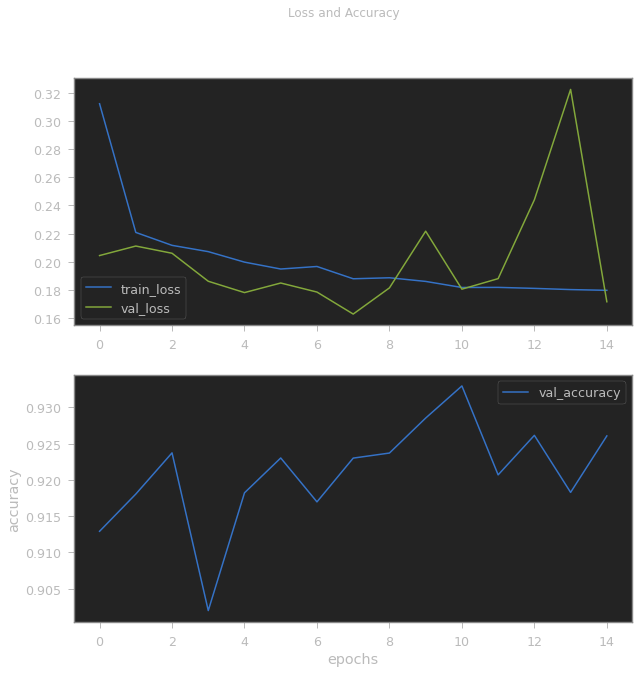

In [77]:
plot_loss_acc(history)

In [ ]:
import segmentation_models_pytorch as smp
from Losses import ComboLoss, dice_metric

In [ ]:
ENCODER          = 'se_resnext50_32x4d'
ENCODER_WEIGHTS  = 'imagenet'
CLASSES          = ['mask']
ACTIVATION       = None
CRITERION        = ComboLoss(**{'weights':{'bce':3, 'dice':1, 'focal':4}})

In [ ]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()

In [ ]:
class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)

    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

In [ ]:
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

In [ ]:
model = model.to(DEVICE)

In [ ]:
max_epochs = 5
optim = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=WEIGHT_DECAY)

In [ ]:
criterion = MixedLoss(10.0, 2.0) 

In [ ]:
history = train(model,optim,criterion,train_loader,val_loader,epochs=max_epochs, vis=False)

In [ ]:
plot_loss_acc(history)